In [2]:
import numpy as np
import pandas as pd
import itertools
import os
import errno
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Define directory-generating function
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [9]:
# Plot single track

#bpath = './output_files/cluster_trials/event_27/2/'
bpath='./'

# find dimensionality of data
n_part=len(pd.read_table(bpath+'Nbody_positions.dat', delim_whitespace=True, nrows=1).T)/3

# for column names, legends, and axes labels
numbers=np.arange(n_part)+1
numbers=[str(i) for i in numbers]
part_labels=['x','y','z']
names=map(''.join, itertools.product(numbers,part_labels))
names=[i[::-1] for i in names]
names = np.reshape(names, (n_part,3))

colors=['b','r','g','m']


### load data
pos=pd.read_table(bpath+'Nbody_positions.dat', delim_whitespace=True, names=names.flatten())
vel=pd.read_table(bpath+'Nbody_velocities.dat', delim_whitespace=True, names=names.flatten())
time=np.squeeze(pd.read_table(bpath+'Nbody_times.dat', delim_whitespace=True, usecols=[0], header=None))

print 'length of data: %i' % len(pos)


length of data: 723492


In [186]:
# for only plotting a subset of the particles
names = names[[0,1,3]]

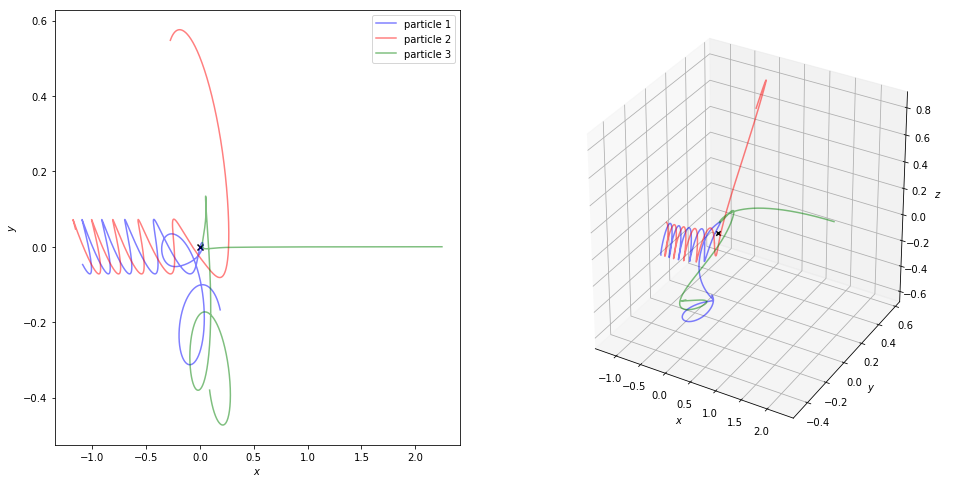

In [13]:
# 2d & 3d static plot
%matplotlib inline
fig = plt.figure(figsize=(16,8))

# set bounds of steps to plot
b=0
f=5000

ax1 = fig.add_subplot((121))
for i, dim in enumerate(names):
    ax1.plot((pos[dim[0]])[b:f],(pos[dim[1]])[b:f], color=colors[i], label='particle '+str(i+1), alpha=0.5)
ax1.scatter([0],[0],marker='x',color='k')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
plt.legend()



# 3d plot
ax2 = fig.add_subplot((122), projection='3d')
for i, dim in enumerate(names):
    ax2.plot((pos[dim[0]])[b:f],(pos[dim[1]])[b:f], (pos[dim[2]])[b:f], color=colors[i], label='particle '+str(i+1), alpha=0.5)
ax2.scatter([0],[0],[0],marker='x',color='k')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
ax2.set_zlabel(r'$z$')

#plt.suptitle('Event Number: %s' % num)

#_ = plt.axis('equal')
#plt.savefig('test')


In [106]:
# loops over all events
for num in xrange(52):
    num = str(num)
    bpath='output/4_body/'+num+'/'
    n_part=4
    numbers=np.arange(n_part)+1
    numbers=[str(i) for i in numbers]
    part_labels=['x','y','z']
    names=map(''.join, itertools.product(numbers,part_labels))
    names=[i[::-1] for i in names]

    ics = pd.read_csv('ICs.txt', sep=' ', index_col=None)
    m11=np.float(ics['m11'])
    m12=np.float(ics['m12'])
    m21=np.float(ics['m11'])
    m22=np.float(ics['m12'])
    a1=np.float(ics['a1'])
    e1=np.float(ics['e1'])
    a2=np.float(ics['a2'])
    e2=np.float(ics['e2'])

    ### load data

    pos=pd.read_table(bpath+'NbodyTides_dataout_pos.dat', delim_whitespace=True, names=names)
    vel=pd.read_table(bpath+'NbodyTides_dataout_vel.dat', delim_whitespace=True, names=names)
    time=np.squeeze(pd.read_table(bpath+'NbodyTides_dataout_a1a2a3.dat', delim_whitespace=True, usecols=[0], header=None))



    # 2d plot
    %matplotlib inline
    fig = plt.figure(figsize=(16,8))

    b=0
    f=10000

    ax1 = fig.add_subplot((121))
    ax1.plot((pos['x1'])[b:f],(pos['y1'])[b:f], color='b', label='particle 1')
    ax1.plot((pos['x2'])[b:f],(pos['y2'])[b:f], color='r', label='particle 2')
    ax1.plot((pos['x3'])[b:f],(pos['y3'])[b:f], color='g', label='particle 3')
    ax1.plot((pos['x4'])[b:f],(pos['y4'])[b:f], color='m', label='particle 4')
    ax1.scatter([0],[0],marker='x',color='k')
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    plt.legend()



    # 3d plot
    ax2 = fig.add_subplot((122), projection='3d')
    ax2.plot((pos['x1'])[b:f],(pos['y1'])[b:f], (pos['z1'])[b:f], color='b', label='particle 1')
    ax2.plot((pos['x2'])[b:f],(pos['y2'])[b:f], (pos['z2'])[b:f], color='r', label='particle 2')
    ax2.plot((pos['x3'])[b:f],(pos['y3'])[b:f], (pos['z3'])[b:f], color='g', label='particle 3')
    ax2.plot((pos['x4'])[b:f],(pos['y4'])[b:f], (pos['z4'])[b:f], color='m', label='particle 4')
    ax2.scatter([0],[0],[0],marker='x',color='k')
    ax2.set_xlabel(r'$x$')
    ax2.set_ylabel(r'$y$')
    ax2.set_zlabel(r'$z$')

    plt.suptitle('Event Number %s' % num)

    plt.axis('equal')
    plt.savefig('plots/'+num)

KeyboardInterrupt: 

Let's make a movie!

In [76]:
path='movies/event_4/1/'
bpath='output/'+path
n_part=4
ax_scale=1.0 # scale the axis from the initial separation value

numbers=np.arange(n_part)+1
numbers=[str(i) for i in numbers]
part_labels=['x','y','z']
names=map(''.join, itertools.product(numbers,part_labels))
names=[i[::-1] for i in names]



ICs = pd.read_table(bpath+'Nbody_initial_conditions.txt', delim_whitespace=True, names=['m','r','x','y','z','vx','vy','vz'])

pos=pd.read_table(bpath+'NbodyTides_dataout_pos.dat', delim_whitespace=True, names=names)
vel=pd.read_table(bpath+'NbodyTides_dataout_vel.dat', delim_whitespace=True, names=names)
time=np.squeeze(pd.read_table(bpath+'NbodyTides_dataout_a1a2a3.dat', delim_whitespace=True, usecols=[0], header=None))
print len(pos)

4612287


In [78]:
# take 2 with constant steps in time


tot_steps=500
t_fine=0.01 # spend half of the steps on this portion of the track
t_lim=4826136.2807 # scale the total time of integration

steps1=np.linspace(0, t_fine*time.max(), tot_steps/2)
steps2=np.linspace(t_fine*time.max(), t_lim*time.max(), tot_steps/2)
steps=np.concatenate((steps1,steps2[1:]))  # otherwise we repeat the last step
steps=np.linspace(0, t_lim, tot_steps)
ss=20
lw=2

def CoM_2d(m1,m2,x1,y1,x2,y2):
    CM_x = (x1*m1 + x2*m2)/(m1+m2)
    CM_y = (y1*m1 + y2*m2)/(m1+m2)
    return CM_x, CM_y

def CoM_3d(m1,m2,m3,x1,y1,z1,x2,y2,z2):
    CM_x = (x1*m1 + x2*m2)/(m1+m2)
    CM_y = (y1*m1 + y2*m2)/(m1+m2)
    CM_z = (z1*m1 + z2*m2)/(m1+m2)
    return CM_x, CM_y, CM_z

for i in xrange(len(steps)-1):
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot((121))
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax1.grid(True)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.scatter([0],[0],marker='x',color='k')
    
    # scale axis by initial position
    # Follow the CM of 2 of the bodies
    CM_x,CM_y = CoM_2d(ICs['m'].iloc[0],ICs['m'].iloc[1],\
                    pos['x1'].iloc[i],pos['y1'].iloc[i],\
                    pos['x2'].iloc[i],pos['y2'].iloc[i])
    # Or, uncomment this out to just stick in the center
    #ax1.set_xlim([((CM_x+pos['x1'].iloc[0])*ax_scale), ((CM_x+pos['x3'].iloc[0])*ax_scale)])
    #ax1.set_ylim((CM_y+pos['y1'].iloc[0])*ax_scale, (CM_y+pos['y3'].iloc[0])*ax_scale)
    #ax1.set_xlim(-50000, 50000)
    #ax1.set_ylim(-6000, 6000)
    # Or, scale axis by max position
    #ax1.set_xlim(min(min(pos['x1']),min(pos['x2']),min(pos['x3']),min(pos['x4'])), \
    #             max(max(pos['x1']),max(pos['x2']),max(pos['x3']),max(pos['x4'])))
    #ax1.set_ylim(min(min(pos['y1']),min(pos['y2']),min(pos['y3']),min(pos['y4'])), \
    #             max(max(pos['y1']),max(pos['y2']),max(pos['y3']),max(pos['y4'])))

    ax1.scatter(np.asarray(pos['x1'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['y1'])[(time>steps[i])&(time<steps[i+1])][-1], color='b', \
                label=('m11=%.2f' % ICs['m'].iloc[0]), marker='o', s=ss*(ICs['m'].iloc[0]/ICs['m'].max())**2)
    ax1.scatter(np.asarray(pos['x2'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['y2'])[(time>steps[i])&(time<steps[i+1])][-1], color='r', \
                label=('m12=%.2f' % ICs['m'].iloc[1]), marker='o', s=ss*(ICs['m'].iloc[1]/ICs['m'].max())**2)
    ax1.scatter(np.asarray(pos['x3'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['y3'])[(time>steps[i])&(time<steps[i+1])][-1], color='g', \
                label=('m21=%.2f' % ICs['m'].iloc[2]), marker='o', s=ss*(ICs['m'].iloc[2]/ICs['m'].max())**2)
    ax1.scatter(np.asarray(pos['x4'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['y4'])[(time>steps[i])&(time<steps[i+1])][-1], color='m', \
                label=('m22=%.2f' % ICs['m'].iloc[3]), marker='o', s=ss*(ICs['m'].iloc[3]/ICs['m'].max())**2)

    plt.legend(loc='upper left')
    
    ax1.plot(np.asarray(pos['x1'])[(time<steps[i+1])],(pos['y1'])[(time<steps[i+1])], lw=lw, color='b', alpha=0.1)
    ax1.plot(np.asarray(pos['x2'])[(time<steps[i+1])],(pos['y2'])[(time<steps[i+1])], lw=lw, color='r', alpha=0.1)
    ax1.plot(np.asarray(pos['x3'])[(time<steps[i+1])],(pos['y3'])[(time<steps[i+1])], lw=lw, color='g', alpha=0.1)
    ax1.plot(np.asarray(pos['x4'])[(time<steps[i+1])],(pos['y4'])[(time<steps[i+1])], lw=lw, color='m', alpha=0.1)

    if i>0:
        ax1.plot(np.asarray(pos['x1'])[(time>steps[i])&(time<steps[i+1])],\
                 (pos['y1'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='b')
        ax1.plot(np.asarray(pos['x2'])[(time>steps[i])&(time<steps[i+1])],\
                 (pos['y2'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='r')
        ax1.plot(np.asarray(pos['x3'])[(time>steps[i])&(time<steps[i+1])],\
                 (pos['y3'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='g')
        ax1.plot(np.asarray(pos['x4'])[(time>steps[i])&(time<steps[i+1])],\
                 (pos['y4'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='m')

    if i>1:
        ax1.plot(np.asarray(pos['x1'])[(time>steps[i-1])&(time<steps[i])],\
                 (pos['y1'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='b', alpha=0.5)
        ax1.plot(np.asarray(pos['x2'])[(time>steps[i-1])&(time<steps[i])],\
                 (pos['y2'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='r', alpha=0.5)
        ax1.plot(np.asarray(pos['x3'])[(time>steps[i-1])&(time<steps[i])],\
                 (pos['y3'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='g', alpha=0.5)
        ax1.plot(np.asarray(pos['x4'])[(time>steps[i-1])&(time<steps[i])],\
                 (pos['y4'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='m', alpha=0.5)

    if i>2: 
        ax1.plot(np.asarray(pos['x1'])[(time>steps[i-2])&(time<steps[i-1])],\
                 (pos['y1'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='b', alpha=0.3)
        ax1.plot(np.asarray(pos['x2'])[(time>steps[i-2])&(time<steps[i-1])],\
                 (pos['y2'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='r', alpha=0.3)
        ax1.plot(np.asarray(pos['x3'])[(time>steps[i-2])&(time<steps[i-1])],\
                 (pos['y3'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='g', alpha=0.3)
        ax1.plot(np.asarray(pos['x4'])[(time>steps[i-2])&(time<steps[i-1])],\
                 (pos['y4'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='m', alpha=0.3)



    ax2 = fig.add_subplot((122), projection='3d')
    ax2.set_xlabel(r'$x$')
    ax2.set_ylabel(r'$y$')
    ax2.set_zlabel(r'$z$')
    ax2.grid(True)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_zticklabels([])
    ax2.scatter([0],[0],[0],marker='x',color='k')
    
    # Follow the CM of 2 of the bodies
    CM_x,CM_y,CM_z = CoM_3d(ICs['m'].iloc[0],ICs['m'].iloc[1],ICs['m'].iloc[2],\
                            pos['x1'].iloc[i+1],pos['y1'].iloc[i+1],pos['z1'].iloc[i+1],\
                            pos['x2'].iloc[i+1],pos['y2'].iloc[i+1],pos['z2'].iloc[i+1])
    #ax2.set_xlim((CM_x+pos['x1'].iloc[0])*ax_scale, (CM_x+pos['x3'].iloc[0])*ax_scale)
    #ax2.set_ylim((CM_y+pos['y1'].iloc[0])*ax_scale, (CM_y+pos['y3'].iloc[0])*ax_scale)
    #ax2.set_zlim((CM_z+pos['z1'].iloc[0])*ax_scale, (CM_z+pos['z3'].iloc[0])*ax_scale)
    #ax2.set_xlim(-50000, 50000)
    #ax2.set_ylim(-6000, 6000)
    #ax2.set_zlim(-20000, 20000)
    
    '''ax2.set_xlim(min(min(pos['x1']),min(pos['x2']),min(pos['x3']),min(pos['x4'])), \
                 max(max(pos['x1']),max(pos['x2']),max(pos['x3']),max(pos['x4'])))
    ax2.set_ylim(min(min(pos['y1']),min(pos['y2']),min(pos['y3']),min(pos['y4'])), \
                 max(max(pos['y1']),max(pos['y2']),max(pos['y3']),max(pos['y4'])))
    ax2.set_zlim(min(min(pos['z1']),min(pos['z2']),min(pos['z3']),min(pos['z4'])), \
                 max(max(pos['z1']),max(pos['z2']),max(pos['z3']),max(pos['z4'])))'''

    ax2.scatter(np.asarray(pos['x1'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['y1'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['z1'])[(time>steps[i])&(time<steps[i+1])][-1], \
                color='b', marker='o', s=ss*(ICs['m'].iloc[0]/ICs['m'].max())**2)
    ax2.scatter(np.asarray(pos['x2'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['y2'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['z2'])[(time>steps[i])&(time<steps[i+1])][-1], \
                color='r', marker='o', s=ss*(ICs['m'].iloc[1]/ICs['m'].max())**2)
    ax2.scatter(np.asarray(pos['x3'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['y3'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['z3'])[(time>steps[i])&(time<steps[i+1])][-1], \
                color='g', marker='o', s=ss*(ICs['m'].iloc[2]/ICs['m'].max())**2)
    ax2.scatter(np.asarray(pos['x4'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['y4'])[(time>steps[i])&(time<steps[i+1])][-1],\
                np.asarray(pos['z4'])[(time>steps[i])&(time<steps[i+1])][-1], \
                color='m', marker='o', s=ss*(ICs['m'].iloc[3]/ICs['m'].max())**2)
    
    ax2.plot(np.asarray(pos['x1'])[(time<steps[i+1])],(pos['y1'])[(time<steps[i+1])], \
             (pos['z1'])[(time<steps[i+1])], lw=lw, color='b', alpha=0.1)
    ax2.plot(np.asarray(pos['x2'])[(time<steps[i+1])],(pos['y2'])[(time<steps[i+1])], \
             (pos['z2'])[(time<steps[i+1])], lw=lw, color='r', alpha=0.1)
    ax2.plot(np.asarray(pos['x3'])[(time<steps[i+1])],(pos['y3'])[(time<steps[i+1])], \
             (pos['z3'])[(time<steps[i+1])], lw=lw, color='g', alpha=0.1)
    ax2.plot(np.asarray(pos['x4'])[(time<steps[i+1])],(pos['y4'])[(time<steps[i+1])], \
             (pos['z4'])[(time<steps[i+1])], lw=lw, color='m', alpha=0.1)


    if i>0:
        ax2.plot(np.asarray(pos['x1'])[(time>steps[i])&(time<steps[i+1])],\
                 np.asarray(pos['y1'])[(time>steps[i])&(time<steps[i+1])], \
                 np.asarray(pos['z1'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='b')
        ax2.plot(np.asarray(pos['x2'])[(time>steps[i])&(time<steps[i+1])],\
                 np.asarray(pos['y2'])[(time>steps[i])&(time<steps[i+1])], \
                 np.asarray(pos['z2'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='r')
        ax2.plot(np.asarray(pos['x3'])[(time>steps[i])&(time<steps[i+1])],\
                 np.asarray(pos['y3'])[(time>steps[i])&(time<steps[i+1])], \
                 np.asarray(pos['z3'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='g')
        ax2.plot(np.asarray(pos['x4'])[(time>steps[i])&(time<steps[i+1])],\
                 np.asarray(pos['y4'])[(time>steps[i])&(time<steps[i+1])], \
                 np.asarray(pos['z4'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='m')

    if i>1:
        ax2.plot(np.asarray(pos['x1'])[(time>steps[i-1])&(time<steps[i])],\
                 np.asarray(pos['y1'])[(time>steps[i-1])&(time<steps[i])], \
                 np.asarray(pos['z1'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='b', alpha=0.5)
        ax2.plot(np.asarray(pos['x2'])[(time>steps[i-1])&(time<steps[i])],\
                 np.asarray(pos['y2'])[(time>steps[i-1])&(time<steps[i])], \
                 np.asarray(pos['z2'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='r', alpha=0.5)
        ax2.plot(np.asarray(pos['x3'])[(time>steps[i-1])&(time<steps[i])],\
                 np.asarray(pos['y3'])[(time>steps[i-1])&(time<steps[i])], \
                 np.asarray(pos['z3'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='g', alpha=0.5)
        ax2.plot(np.asarray(pos['x4'])[(time>steps[i-1])&(time<steps[i])],\
                 np.asarray(pos['y4'])[(time>steps[i-1])&(time<steps[i])], \
                 np.asarray(pos['z4'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='m', alpha=0.5)

    if i>2: 
        ax2.plot(np.asarray(pos['x1'])[(time>steps[i-2])&(time<steps[i-1])],\
                 np.asarray(pos['y1'])[(time>steps[i-2])&(time<steps[i-1])], \
                 np.asarray(pos['z1'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='b', alpha=0.3)
        ax2.plot(np.asarray(pos['x2'])[(time>steps[i-2])&(time<steps[i-1])],\
                 np.asarray(pos['y2'])[(time>steps[i-2])&(time<steps[i-1])], \
                 np.asarray(pos['z2'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='r', alpha=0.3)
        ax2.plot(np.asarray(pos['x3'])[(time>steps[i-2])&(time<steps[i-1])],\
                 np.asarray(pos['y3'])[(time>steps[i-2])&(time<steps[i-1])], \
                 np.asarray(pos['z3'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='g', alpha=0.3)
        ax2.plot(np.asarray(pos['x4'])[(time>steps[i-2])&(time<steps[i-1])],\
                 np.asarray(pos['y4'])[(time>steps[i-2])&(time<steps[i-1])], \
                 np.asarray(pos['z4'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='m', alpha=0.3)

    plt.suptitle('t = %i' % time[i], fontsize=20)
    
    mkdir_p('images/'+path)
    plt.savefig('images/'+path+str(i).zfill(4))
    plt.close()